In [1]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range, input


import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

# load in the data
df = pd.read_csv('large_files/movielens-20m-dataset/edited_rating.csv')

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
# reg = 0.0001 # regularization penalty
#nota: os warnings exibidos abaixo são provenientes do uso do tensorflow com a gpu e versoes do numpy suportadas

Using TensorFlow backend.
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\d

In [2]:
# utilizamos o vetor de features de usuario e filme concatenados criado pelo KERAS como entrada da rede neural
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)


In [3]:
# the neural network
x = Dense(700)(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(200)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)

In [4]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  )
)



Train on 16000210 samples, validate on 4000053 samples
Epoch 1/15
16000210/16000210 [==============================] - 699s 44us/step - loss: 1.1180 - mse: 1.1180 - val_loss: 1.1139 - val_mse: 1.1139
Epoch 2/15
16000210/16000210 [==============================] - 692s 43us/step - loss: 1.1138 - mse: 1.1138 - val_loss: 1.1150 - val_mse: 1.1150
Epoch 3/15
16000210/16000210 [==============================] - 688s 43us/step - loss: 1.1138 - mse: 1.1138 - val_loss: 1.1083 - val_mse: 1.1083
Epoch 4/15
16000210/16000210 [==============================] - 688s 43us/step - loss: 1.1138 - mse: 1.1139 - val_loss: 1.1076 - val_mse: 1.1076
Epoch 5/15
16000210/16000210 [==============================] - 705s 44us/step - loss: 1.1139 - mse: 1.1139 - val_loss: 1.1075 - val_mse: 1.1075
Epoch 6/15
16000210/16000210 [==============================] - 718s 45us/step - loss: 1.1137 - mse: 1.1137 - val_loss: 1.1155 - val_mse: 1.1155
Epoch 7/15
16000210/16000210 [==============================] - 666s 42us/

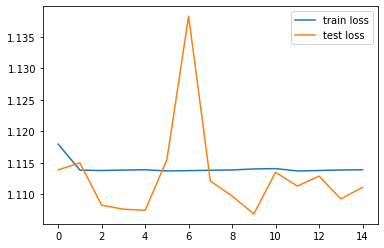

In [5]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

In [6]:
#Plotamos o erro quadratico medio caso utilizemos regularizacao
# plot mse
#plt.plot(r.history['mse'], label="train mse")
#plt.plot(r.history['val_mse'], label="test mse")
#plt.legend()
#plt.show()